In [1]:
import json
import numpy as np
import re
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

# Метод наименьших квадратов

Одним из самых известных методов оптимизации алгоритма является метод наименьших квадратов.
Суть метода состоит в том что мы ищем такие параметра алгоритма $\theta$, чтобы минимизировать среднеквадратичную ошибку:
$$\large{MSE = \frac{1}{N}(y_{true} - a(X, \theta))^2\rightarrow min}$$
Поскольку MSE является прямодефиренцируемой функцией мы можем взять производную от нее и приравнять к нулю, для того чтобы найти параметры $\theta$ при которых ошибка минимальна
$$\large{\frac{d(MSE)}{d\theta} = 0}$$
Применяя правило цепи получим:
$$\large{\frac{d(MSE)}{d\theta} = \frac{1}{N}\frac{d(a(X, \theta))}{d\theta}\frac{d(MSE)}{d(a(X, \theta))}} = 0$$
$$\large{\frac{d(MSE)}{d\theta} = \frac{1}{N}\frac{d(a(X, \theta))}{d\theta}(-2y_{true} + 2a(X, \theta))} = 0$$
Для того чтобы решить данное равенство необходим алгоритм, который был дифферецируем по своим параметрам.
Один из самых простых алгоритмов такого типа, линейный где:
$$\large{a(X, \theta) = \sum_{i=1}^{l}{x_iw_i} + b}$$

- $l$ - количество признаков
- $x_i$ - i-й признак
- $w_i$ - вес i-того признака
- $b$ - смещение

В матричном виде, алгоритм выглядит следующим образом
$$\large{a(X, \theta) = XW + b}$$

- $X\in\mathbb{R}^{m*l}$ - матрица признаков, датасет из $m$ строк и $l$ признаков
- $W\in\mathbb{R}^{l*1}$ - вектор весов
- $b\in\mathbb{R}$ - скаляр смещения

Часто для удобства записи алгоритма вводят специальный признак $x_0 = 1$, для того чтобы параметр смещения занести внутрь матрицы весов
$$\large{a(X, \theta) = XW}$$

- $X\in\mathbb{R}^{m*(l+1)}$ - матрица признаков, датасет из $m$ строк и $l$ признаков
- $W\in\mathbb{R}^{(l+1)*1}$ - вектор весов

В данном алгоритме параметр $\theta$ - это только веса, перепишем MSE учитывая выбранный алгоритм
$$\large{\frac{d(MSE)}{dW} = \frac{1}{n}\frac{d(XW)}{dW}(-2y_{true} + 2XW)}$$
$$\large{\frac{d(MSE)}{dW} = \frac{1}{n}X^T(-2y_{true} + 2XW)}$$
$$\large{\frac{-2X^Ty_{true}}{n} + \frac{2X^TXW}{n} = 0}$$
$$\large{X^TXW = X^Ty_{true}}$$
$$\large{W = (X^TX)^{-1}X^Ty_{true}}$$
Как видно данная задача имеет аналитическое решение

In [2]:
np.random.seed(42)

In [3]:
x = np.linspace(1, 10, 101)

In [4]:
y = x + np.random.randn(101) + 2

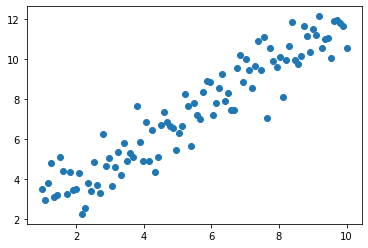

In [5]:
plt.scatter(x, y);

In [6]:
x = np.vstack([[1]*x.shape[0], x]).T

In [7]:
x[:5]

array([[1.  , 1.  ],
       [1.  , 1.09],
       [1.  , 1.18],
       [1.  , 1.27],
       [1.  , 1.36]])

In [8]:
y = y.reshape(-1, 1)

In [9]:
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

In [10]:
w

array([[1.84720819],
       [1.00653816]])

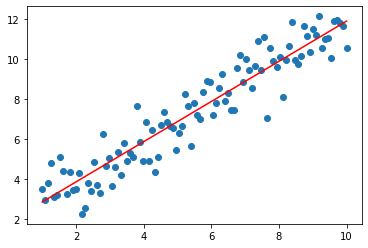

In [11]:
plt.scatter(x[:,1], y[:,0]);
plt.plot(x[:,1], x.dot(w)[:,0], 'r');

In [12]:
mean_squared_error(y[:,0], x.dot(w)[:,0])

0.8250055304982957

## Разброс и смещение решения

Разберем на составные части функцию ошибок:
$$\large{MSE = \mathbb{E}[(y_{true} - y_{pred})^2]}$$
$$\large{MSE = \mathbb{E}[y_{true}^2] + \mathbb{E}[y_{pred}^2] - 2\mathbb{E}[y_{true}y_{pred}]}$$
Также по свойству дисперсии
$$\large{Var(z) = \mathbb{E}[z^2] - \mathbb{E}[z]^2}$$
Из этого следует что:
$$\large{\mathbb{E}[y_{true}^2] = Var(y_{true}) + \mathbb{E}[y_{true}]^2}$$
$$\large{\mathbb{E}[y_{pred}^2] = Var(y_{pred}) + \mathbb{E}[y_{pred}]^2}$$
$$\large{MSE = Var(y_{true}) + \mathbb{E}[y_{true}]^2 + Var(y_{pred}) + \mathbb{E}[y_{pred}]^2 - 2\mathbb{E}[y_{true}y_{pred}]}$$
Поскольку ошибка и целевая переменная независимы друг от друга
$$\large{MSE = Var(y_{true}) + \mathbb{E}[y_{true}]^2 + Var(y_{pred}) + \mathbb{E}[y_{pred}]^2 - 2\mathbb{E}[y_{true}]\mathbb{E}[y_{pred}]}$$
$$\large{MSE = Var(y_{true}) + Var(y_{pred}) + (\mathbb{E}[y_{true}] - \mathbb{E}[y_{pred}])^2}$$
$$\large{MSE = \sigma^2 + Var(y_{pred}) + Bias(y_{pred})}^2$$
Как видно ошибка зависит от квадрата смещения и разброса ответа, поскольку $\sigma^2$ - не изменяема и зависит только от целевой переменной

<img src="./img/bias_variance.png" style="width: 500px;">
<img src="./img/bias_variance_target.png">

За метод наименьших квадратов в sklearn отвечает класс LinearRegression из модуля linear_model

Одной из проблем для линейной регрессии является мультиколлинеарность признаков, из-за чего невозможно сосчитать обратную матрицу для линейно-зависимой матрицы
Решением данной проблемы является добавление единичной матрицы к матрице признаков, благодаря чему мультиколлениарность признаков исчезает, и к функции ошибки добавляется l2 норма весов
$$\large{MSE_{new} = MSE + ||W||^2}$$
Чтобы контролировать силу регуляризации модели, к l2 норме добавляют параметр $\lambda$ 
$$\large{MSE_{new} = MSE + \lambda||W||^2}$$
Такой тип регуляризации ведет к более равномерному распределению весов по признакам
Однако мы можем вместо l2 нормы в функции ошибок добавить l1 норму
$$\large{MSE_{new} = MSE + \lambda|W|}$$
И в данном случае, алгоритм будет стремиться занулять ненужные признаки
За функционал с l2 регуляризацией отвечает класс Ridge модуля liner_model
За функционал с l1 регуляризацией отвечает класс Lasso модуля liner_model
Параметр $\lambda$ в данных алгоритм представлен как alpha

<img src="./img/ridge_lasso.png" style="width: 500px;">

In [13]:
data = []
with open('./data/Amazon_Instant_Video_5.json', 'r') as file:
    for line in file:
        data.append(json.loads(line.strip()))

In [14]:
X = [var['reviewText'] for var in data]
Y = [var['overall'] for var in data]

In [15]:
X[:10]

["I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.",
 'I highly recommend this series. It is a must for anyone who is yearning to watch "grown up" television. Complex characters and plots to keep one totally involved. Thank you Amazin Prime.',
 "This one is a real snoozer. Don't believe anything you read or hear, it's awful. I had no idea what the title means. Neither will you.",
 'Mysteries are interesting.  The tension between Robson and the tall blond is good but not always believable.  She often seemed uncomfortable.',
 'This show always is excellent, as far as british crime or mystery showsgoes this is one of the best ever made.  The stories are well done and the acting is top notch with interesting twists in the realistic and brutal storylines.  This show pulls no punches as it enters into the twisted minds of criminals and the profiler psychiatrist who helps out in a no

In [16]:
Y[:10]

[2.0, 5.0, 1.0, 4.0, 5.0, 5.0, 3.0, 3.0, 5.0, 3.0]

In [17]:
X = [re.sub('\W+', ' ', var).strip().lower() for var in X]

In [18]:
X[:10]

['i had big expectations because i love english tv in particular investigative and detective stuff but this guy is really boring it didn t appeal to me at all',
 'i highly recommend this series it is a must for anyone who is yearning to watch grown up television complex characters and plots to keep one totally involved thank you amazin prime',
 'this one is a real snoozer don t believe anything you read or hear it s awful i had no idea what the title means neither will you',
 'mysteries are interesting the tension between robson and the tall blond is good but not always believable she often seemed uncomfortable',
 'this show always is excellent as far as british crime or mystery showsgoes this is one of the best ever made the stories are well done and the acting is top notch with interesting twists in the realistic and brutal storylines this show pulls no punches as it enters into the twisted minds of criminals and the profiler psychiatrist who helps out in a northern english city poli

In [19]:
bow_vect = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.5, token_pattern='\S+')

In [20]:
X_bow = bow_vect.fit_transform(X)

In [21]:
X_bow.shape

(37126, 50571)

In [22]:
%%time
cross_val_score(LinearRegression(), X_bow, Y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

Wall time: 12min 32s


array([-13.30129381, -10.82762853,  -9.2832587 , -10.55984512,
        -5.18579764])

In [22]:
%%time
cross_val_score(Ridge(), X_bow, Y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
%%time
cross_val_score(Lasso(), X_bow, Y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

При большом числе признаков, начинаются проблемы со скоростью вычислений, поскольку алгоритм инвертирования матрицы, выполняется за $O(n^3)$

# Градиентный спуск

Вместо того чтобы пытаться найти аналитическое решение, мы можем воспользоваться методом градиентного спуска.
Формально, градиентный спуск — метод нахождения экстремума (минимума или максимума) функции с помощью движения вдоль градиента
Свойство градиента такого, что градиент посчитанный в любой точке, показывает направление наискорейшего роста функции
А отрицательный градиент показывает скорость скорейшего убывания функция, что нам и необходимо для минимизации функции ошибок

Алгоритм выглядит следующим образом:

- считаем градиент от функции ошибок по весам $\large{\nabla_W = \frac{-2}{n}X^T(y_{true} - XW)}$
- обновляем веса с зараннее определенным шагом $\eta$, $\large{W = W - \eta\nabla_W}$

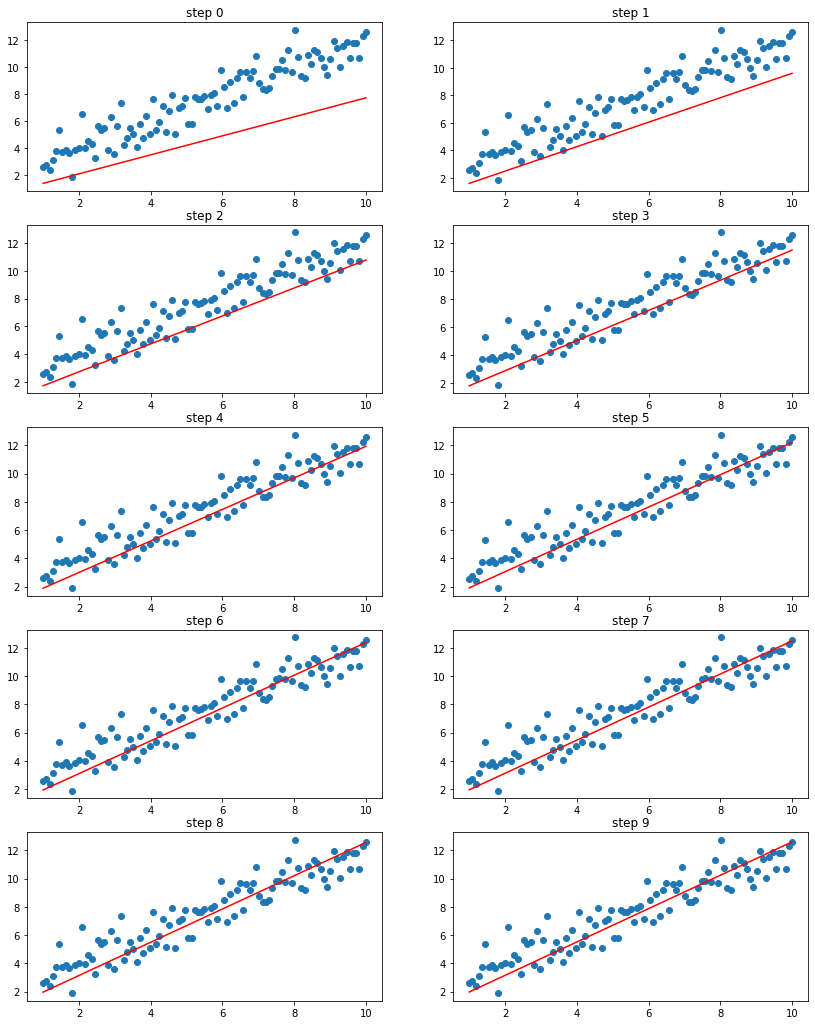

In [24]:
plt.figure(figsize=(14, 18));
x = np.linspace(1, 10, 101)
y = x + np.random.randn(101) + 2
x = np.vstack([[1]*x.shape[0], x]).T
y = y.reshape(-1, 1)
w = np.random.rand(2, 1)
eta = 0.005
for i in range(10):
    plt.subplot(5, 2, i+1);
    plt.scatter(x[:,1], y[:,0]);
    plt.plot(x[:, 1], x.dot(w)[:,0], 'r')
    plt.title(f'step {i}')
    grad_w = -2/x.shape[0]*x.T.dot(y - x.dot(w))
    w -= eta*grad_w

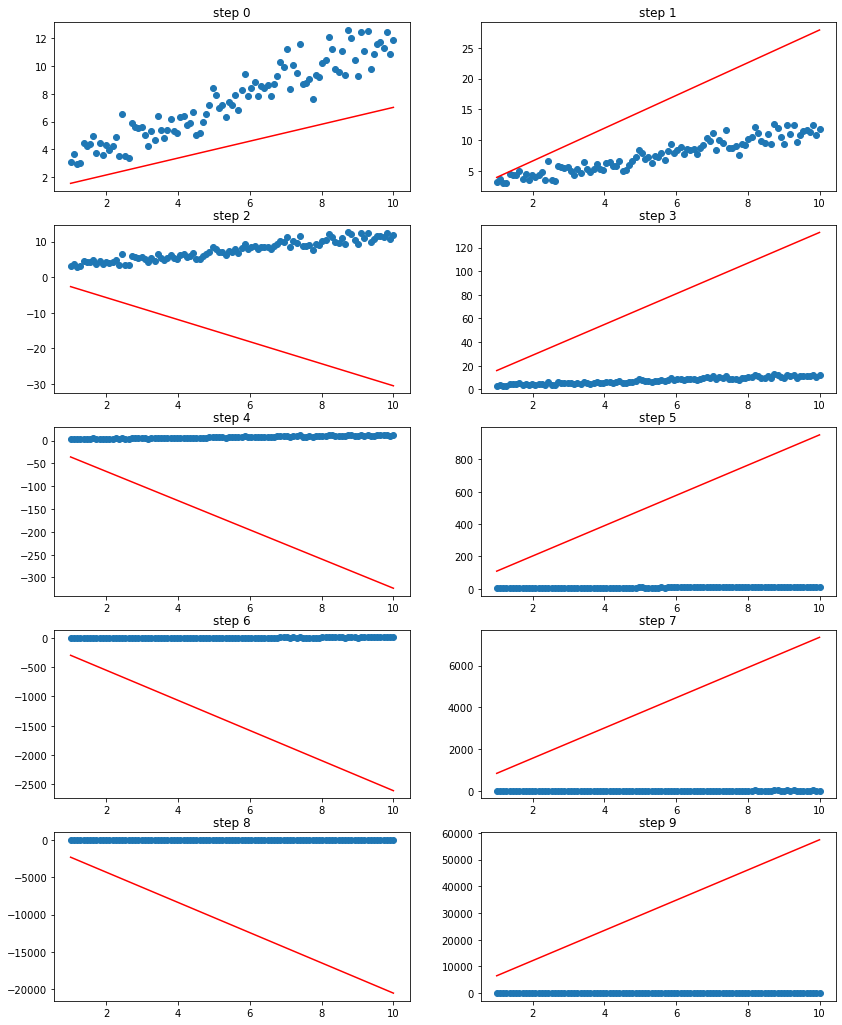

In [26]:
plt.figure(figsize=(14, 18));
x = np.linspace(1, 10, 101)
y = x + np.random.randn(101) + 2
x = np.vstack([[1]*x.shape[0], x]).T
y = y.reshape(-1, 1)
w = np.random.rand(2, 1)
eta = 0.05
for i in range(10):
    plt.subplot(5, 2, i+1);
    plt.scatter(x[:,1], y[:,0]);
    plt.plot(x[:, 1], x.dot(w)[:,0], 'r')
    plt.title(f'step {i}')
    grad_w = -2/x.shape[0]*x.T.dot(y - x.dot(w))
    w -= eta*grad_w

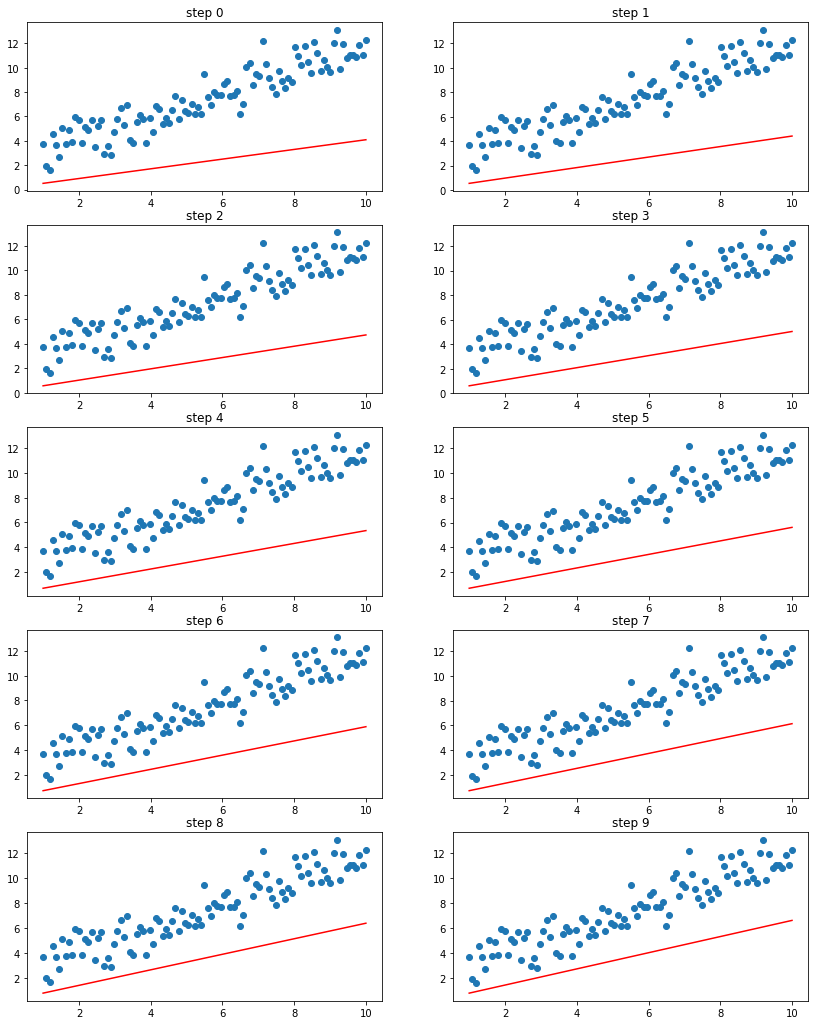

In [27]:
plt.figure(figsize=(14, 18));
x = np.linspace(1, 10, 101)
y = x + np.random.randn(101) + 2
x = np.vstack([[1]*x.shape[0], x]).T
y = y.reshape(-1, 1)
w = np.random.rand(2, 1)
eta = 5e-4
for i in range(10):
    plt.subplot(5, 2, i+1);
    plt.scatter(x[:,1], y[:,0]);
    plt.plot(x[:, 1], x.dot(w)[:,0], 'r')
    plt.title(f'step {i}')
    grad_w = -2/x.shape[0]*x.T.dot(y - x.dot(w))
    w -= eta*grad_w

При использовании алгоритма градиентного спуска следует быть осторожным с параметром $\eta$, поскольку слишком большие значения не позволят найти минимум функции из-за того что мы будем перепрыгивать минимум, а слишком маленькие значения дают очень медленную сходимость
<img src='./img/learning_rate.png'>
Как и большинство гиперпараметров $\eta$ настраивают по кросс валидации

Градиентный спуск дает ускорение обучения, но иногда и его недостаточно. Происходит это из-за того мы считаем градиент на всех примерах. Однако мы можем обновлять веса по градиенту одного случайно посчитаного примера. Такой метод называется Стохастический градиентный спуск (stochastic gradient descent). SGD требуется больше шагов чтобы достичь оптимума, однако из-за того что скорость каждого шага выше, алгоритм сходится быстрее.
В sklearn SGD представлен классом SGDRegressor, модуля linear_models. Параметр $\eta$ преставлен как $learning\_rate=\frac{1}{\eta}$

<img src="./img/sgd.png">

In [28]:
%%time
cross_val_score(SGDRegressor(), X_bow, Y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

CPU times: user 299 ms, sys: 110 ms, total: 409 ms
Wall time: 3.04 s


array([-1.38231781e+08, -1.18211647e+06, -1.02160572e+13, -6.93925934e+06,
       -6.29234073e+10])

Неравномерность масштабирования данных, так же является большой проблемой для алгоритма градиентного спуска, поскольку зависимость функции ошибки по весам становится неравномерной и минимизируются только веса с большим масштабом

<img src="./img/gd_normalize.png" style="width: 500px;">

$$\large{x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}}$$

In [29]:
scaler = MaxAbsScaler()

In [30]:
scaler.fit(X_bow)

MaxAbsScaler()

In [31]:
scaler = StandartScaler()

NameError: name 'StandartScaler' is not defined

$$\large{x_{new} = \frac{x - \mu}{\sigma}}$$

In [30]:
X_bow_scale = scaler.fit_transform(X_bow)

In [31]:
%%time
cross_val_score(SGDRegressor(), X_bow_scale, Y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

Wall time: 3.94 s


array([-1.23938478, -1.00167919, -0.96097731, -1.03716608, -1.11176797])